In [1]:
import numpy as np
import pandas as pd
import mne
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [3]:
path = Path('../data/asd/raw')
freqs = np.linspace(4, 12, 41)

info = pd.read_csv(path / 'path_file.csv')
info['fn'] = info['fn'].str.replace('и' + chr(774), 'й') # For some reason, filenames encode й as 2 unicode characters
info = info.groupby("fn").filter(lambda x: len(x) == 1)
info.reset_index(drop=True, inplace=True)
typical = np.where(info['target'] == 'typical')[0]
asd = np.where(info['target'] == 'asd')[0]

eegs = {i: mne.io.read_raw_fif(path / fn, verbose=False) for i, fn in info['fn'].items()}
ch_names = eegs[0].ch_names

assert np.all([eegs[i].info['sfreq'] == sfreq for i, sfreq in info['sfreq'].items()])

info

,fn,target,dataset_name,sfreq,age,seconds
0,sedrykyn_sasha_7_og_concat_19.raw.fif,asd,asd,125,7,47.0
1,roma gritchin _5_fon_open_19.raw.fif,asd,asd,125,5,33.0
2,boy5_asd_og_new_19.raw.fif,asd,asd,125,5,50.0
3,viflyancev_4_asd_fon__concat_19.raw.fif,asd,asd,125,4,58.0
4,andrey_matveev3_asd_new_19.raw.fif,asd,asd,125,3,50.0
...,...,...,...,...,...,...
322,artem_sarkis_6_fon_19.raw.fif,typical,typical,125,6,44.0
323,gusarova_9_norm_19.raw.fif,typical,typical,125,9,83.0
324,акулов миша 10 от даши_ог_19.raw.fif,typical,typical,125,10,42.0
325,жавнис_3_19.raw.fif,typical,typical,125,3,386.0


In [4]:
bins = [2, 5, 7, 10]
info["age group"] = np.digitize(info["age"], bins)

In [5]:
def get_powers(signal, fmin=4, fmax=8, sfreq=125):
    epoch = signal[np.newaxis]
    freqs = np.linspace(fmin, fmax)
    return mne.time_frequency.tfr_array_morlet(epoch,
                                               sfreq=sfreq,
                                               freqs=freqs,
                                               output='power',
                                               verbose=False)[0].mean(axis=1)

# def filters(age):
#     if age in range(2, 5):
#         return 4, 12
#     if age in range(5, 7):
#         return 5, 12
#     if age in range(7, 10):
#         return 6, 13
#     return 7, 13

def find_borders(arr):
    return np.where(np.pad(arr, (1, 0))[:-1] < arr), np.where(arr > np.pad(arr, (0, 1))[1:])

def filter_index(index, times, n_seconds, threshold):
    mask = index > threshold
    index_vals = []
    for chan in mask:
        index_val = 0.
        start_ix, end_ix = find_borders(chan)
        for start, end in zip(times[start_ix], times[end_ix]):
            if end - start < .1:
                continue
            index_val += end - start
        index_vals.append(index_val / n_seconds)
    return np.array(index_vals)

In [6]:
def index_1(eeg, fmin, fmax):
    alpha_powers = get_powers(eeg, fmin=fmin, fmax=fmax)
    beta_powers = get_powers(eeg, fmin=13, fmax=30)
    return alpha_powers / beta_powers

def index_2(eeg, fmin, fmax):
    alpha_powers = get_powers(eeg, fmin=fmin, fmax=fmax)
    beta_power = mne.time_frequency.psd_array_welch(eeg, sfreq=125, fmin=13, fmax=30, verbose=False)[0].mean(axis=1)
    return alpha_powers / beta_power[:, None]

In [7]:
beta_powers = [get_powers(eeg[:][0], fmin=13, fmax=30) for eeg in tqdm(eegs.values())]
mean_beta = [mne.time_frequency.psd_array_welch(
                eeg[:][0],
                sfreq=125,
                fmin=13,
                fmax=30,
                verbose=False
            )[0].mean(axis=1) for eeg in tqdm(eegs.values())]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

In [8]:
alpha_powers = {}
alpha_powers["2-6"] = [get_powers(eeg[:][0], 2, 6) for eeg in tqdm(eegs.values())]
alpha_powers["4-8"] = [get_powers(eeg[:][0], 4, 8) for eeg in tqdm(eegs.values())]
alpha_powers["8-13"] = [get_powers(eeg[:][0], 8, 13) for eeg in tqdm(eegs.values())]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

In [9]:
indices_raw_1 = {}
for kind, alpha_power in alpha_powers.items():
    indices_raw_1[kind] = [a / b for a, b in zip(alpha_power, beta_powers)]


In [10]:
indices_raw_2 = {}
for kind, alpha_power in alpha_powers.items():
    indices_raw_2[kind] = [a / m_b[:, None] for a, m_b in zip(alpha_power, mean_beta)]


In [11]:
all_index_1 = pd.concat(
{kind: pd.DataFrame([
        filter_index(idx, eeg.times, seconds, 5)
        for idx, eeg, seconds in zip(indices, eegs.values(), info.seconds.values)
    ], index=info["fn"], columns=ch_names)
    for kind, indices in indices_raw_1.items()
})

all_index_1 = all_index_1.join(info.set_index("fn")[["age group", "target"]])
all_index_1.index.set_names("kind", level=0, inplace=True)
all_index_1.fillna(0., inplace=True)


In [12]:
all_index_1[all_index_1["age group"] != 0].groupby(["age group", "kind", "target"]).mean()

Fp1       Fp2        F7        F3        Fz  \
age group kind target                                                      
1         2-6  asd      0.848651  0.848771  0.830807  0.858055  0.877040   
               typical  0.694588  0.704514  0.654572  0.723898  0.761742   
          4-8  asd      0.643487  0.652769  0.602908  0.671031  0.712860   
               typical  0.484013  0.505280  0.445620  0.541856  0.576003   
          8-13 asd      0.222534  0.242473  0.218900  0.274389  0.268915   
               typical  0.200266  0.217205  0.167200  0.254234  0.269069   
2         2-6  asd      0.828693  0.832625  0.784240  0.835063  0.862500   
               typical  0.735470  0.752326  0.695934  0.790087  0.803792   
          4-8  asd      0.608877  0.605440  0.560650  0.629970  0.670553   
               typical  0.521765  0.538331  0.461580  0.591175  0.616143   
          8-13 asd      0.250666  0.226725  0.249200  0.285190  0.288925   
               typical  0.200507  0.214554  0.168352  0.266777  0.266465   
3         2-6  asd      0.753033  0.761555  0.762005  0.795408  0.795990   
               typical  0.723975  0.707246  0.698658  0.757799  0.781021   
          4-8  asd      0.553769  0.544106  0.531572  0.597093  0.613225   
               typical  0.511477  0.495556  0.473028  0.566875  0.603938   
          8-13 asd      0.224296  0.226618  0.206625  0.252961  0.266888   
               typical  0.221763  0.219285  0.213526  0.273772  0.275225   
4         2-6  asd      0.593000  0.590701  0.578974  0.609540  0.598824   
               typical  0.635451  0.618988  0.596276  0.628027  0.669565   
          4-8  asd      0.426331  0.406614  0.386914  0.456790  0.451009   
               typical  0.426004  0.423349  0.374834  0.429208  0.495327   
          8-13 asd      0.183100  0.160839  0.147880  0.191420  0.201613   
               typical  0.208846  0.216663  0.167910  0.201392  0.249805   

                              F4        F8        T3        C3        Cz  \
age group kind target                                                      
1         2-6  asd      0.858895  0.797023  0.763984  0.868429  0.871991   
               typical  0.722209  0.688360  0.656478  0.759888  0.778062   
          4-8  asd      0.676239  0.582599  0.535630  0.696721  0.725953   
               typical  0.550767  0.493711  0.457550  0.585044  0.617473   
          8-13 asd      0.276968  0.222758  0.174604  0.286279  0.327935   
               typical  0.266539  0.203322  0.202073  0.328431  0.349012   
2         2-6  asd      0.834187  0.808997  0.784753  0.833246  0.852551   
               typical  0.769440  0.712154  0.684953  0.771507  0.790605   
          4-8  asd      0.605791  0.551445  0.556176  0.634476  0.662953   
               typical  0.557207  0.469908  0.456477  0.569510  0.598645   
          8-13 asd      0.246995  0.223284  0.245743  0.351046  0.328879   
               typical  0.259231  0.177371  0.173763  0.277243  0.325081   
3         2-6  asd      0.767814  0.738562  0.748949  0.801685  0.830579   
               typical  0.743680  0.676640  0.684750  0.763538  0.796456   
          4-8  asd      0.569748  0.504154  0.528829  0.625184  0.663131   
               typical  0.532680  0.442817  0.453625  0.599944  0.638690   
          8-13 asd      0.238981  0.195616  0.206519  0.318514  0.341056   
               typical  0.257656  0.193969  0.224245  0.348656  0.388722   
4         2-6  asd      0.575136  0.568295  0.528786  0.589807  0.596907   
               typical  0.609607  0.599918  0.543107  0.605385  0.638816   
          4-8  asd      0.415252  0.390599  0.340487  0.436458  0.450461   
               typical  0.426294  0.382894  0.340306  0.430375  0.475861   
          8-13 asd      0.172797  0.143629  0.126583  0.217310  0.259767   
               typical  0.213404  0.181136  0.196517  0.286453  0.295467   

                              C4        T4        T5        P3        Pz  \

In [13]:
all_index_2 = pd.concat(
{kind: pd.DataFrame([
        filter_index(idx, eeg.times, seconds, 770) 
        for idx, eeg, seconds in zip(indices, eegs.values(), info.seconds.values)
    ], index=info["fn"], columns=ch_names)
    for kind, indices in indices_raw_2.items()
})

all_index_2 = all_index_2.join(info.set_index("fn")[["age group", "target"]])
all_index_2.index.set_names("kind", level=0, inplace=True)
all_index_2.fillna(0., inplace=True)

In [14]:
all_index_2[all_index_2["age group"] != 0].groupby(["age group", "kind", "target"]).mean()

Fp1       Fp2        F7        F3        Fz  \
age group kind target                                                      
1         2-6  asd      0.798742  0.809992  0.764428  0.821444  0.845850   
               typical  0.585178  0.595043  0.517194  0.627814  0.677317   
          4-8  asd      0.501965  0.532597  0.455453  0.554220  0.608129   
               typical  0.323616  0.347382  0.288595  0.418402  0.451414   
          8-13 asd      0.099700  0.117207  0.092155  0.155046  0.143373   
               typical  0.092299  0.103973  0.072616  0.150549  0.160331   
2         2-6  asd      0.775776  0.785650  0.708070  0.799493  0.838704   
               typical  0.618658  0.645952  0.571180  0.713752  0.726302   
          4-8  asd      0.474936  0.458852  0.425065  0.521348  0.561675   
               typical  0.370108  0.389955  0.288198  0.461670  0.490401   
          8-13 asd      0.132959  0.107484  0.141393  0.164066  0.172956   
               typical  0.088384  0.109315  0.061936  0.142470  0.153538   
3         2-6  asd      0.660813  0.668031  0.676686  0.723497  0.733158   
               typical  0.602033  0.580551  0.578460  0.670062  0.689042   
          4-8  asd      0.402622  0.385937  0.374503  0.452954  0.478388   
               typical  0.347599  0.328968  0.318486  0.429902  0.465313   
          8-13 asd      0.109061  0.116192  0.096924  0.132699  0.146199   
               typical  0.104251  0.101860  0.104897  0.149846  0.149354   
4         2-6  asd      0.433742  0.450037  0.414223  0.502009  0.486260   
               typical  0.503932  0.492852  0.455091  0.491432  0.557597   
          4-8  asd      0.268125  0.254081  0.216620  0.318511  0.328883   
               typical  0.271508  0.274625  0.213532  0.287672  0.363958   
          8-13 asd      0.075213  0.068643  0.055167  0.092154  0.101496   
               typical  0.104559  0.116813  0.079105  0.100101  0.137620   

                              F4        F8        T3        C3        Cz  \
age group kind target                                                      
1         2-6  asd      0.809511  0.728678  0.660118  0.837142  0.842414   
               typical  0.631285  0.568939  0.523264  0.665606  0.700840   
          4-8  asd      0.550699  0.429148  0.373882  0.589966  0.619648   
               typical  0.421266  0.331156  0.297276  0.459942  0.507527   
          8-13 asd      0.148853  0.107771  0.073440  0.165690  0.193066   
               typical  0.155377  0.094775  0.103758  0.226285  0.235737   
2         2-6  asd      0.795419  0.741495  0.703546  0.802504  0.822906   
               typical  0.681470  0.599425  0.547902  0.695732  0.712855   
          4-8  asd      0.467577  0.397181  0.385667  0.525823  0.560472   
               typical  0.434807  0.315738  0.280551  0.441280  0.486836   
          8-13 asd      0.125234  0.107782  0.133238  0.231607  0.203384   
               typical  0.155325  0.077863  0.071943  0.164697  0.221719   
3         2-6  asd      0.687380  0.643379  0.642462  0.737212  0.780475   
               typical  0.649962  0.518985  0.560851  0.685658  0.719296   
          4-8  asd      0.424061  0.338583  0.359796  0.496913  0.550594   
               typical  0.379148  0.255738  0.303766  0.474160  0.527884   
          8-13 asd      0.127841  0.092590  0.095981  0.189462  0.221117   
               typical  0.138629  0.084491  0.130364  0.226735  0.267730   
4         2-6  asd      0.434245  0.428833  0.376258  0.465490  0.491759   
               typical  0.482052  0.458855  0.392199  0.477856  0.525600   
          4-8  asd      0.266063  0.227446  0.182566  0.291435  0.325488   
               typical  0.273634  0.234452  0.184995  0.281683  0.337554   
          8-13 asd      0.076024  0.058014  0.053313  0.112468  0.160521   
               typical  0.112701  0.088945  0.102599  0.175117  0.182919   

                              C4        T4        T5        P3        Pz  \

In [15]:
index_samples_1 = all_index_1[all_index_1["age group"] != 0].groupby(["age group", "kind", "target"]).agg(list)
index_samples_2 = all_index_2[all_index_2["age group"] != 0].groupby(["age group", "kind", "target"]).agg(list)

In [16]:
from scipy.stats import mannwhitneyu

In [17]:
def compute_mw_col(col):
    stat, p = mannwhitneyu(*col)
    return {"W": stat, "p": p}

def compute_mw_df(df):
    return pd.DataFrame(df.apply(compute_mw_col).to_dict())

In [18]:
pd.DataFrame(index_samples_1.loc[1, "2-6"].apply(compute_mw_col).to_dict())

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
W,1235.00000,1201.000000,1306.00000,1146.000000,1080.000000,1112.000000,1088.000000,1099.000000,1160.00000,1091.000000,1094.000000,1117.000000,1039.000000,1096.000000,1021.000000,1018.000000,999.000000,1085.000000,1045.00000
p,0.00018,0.000605,0.00001,0.003538,0.021354,0.009326,0.017492,0.013186,0.00231,0.016209,0.015011,0.008134,0.054908,0.014256,0.079796,0.084723,0.121896,0.018862,0.04821


In [19]:
p_values_1 = index_samples_1.groupby(["age group", "kind"]).apply(lambda y: y.apply(lambda x: mannwhitneyu(*x)[1]))
p_values_1

Fp1       Fp2        F7        F3        Fz        F4  \
age group kind                                                               
1         2-6   0.000180  0.000605  0.000010  0.003538  0.021354  0.009326   
          4-8   0.000186  0.000459  0.000346  0.004352  0.003332  0.006151   
          8-13  0.215214  0.151275  0.015401  0.608290  0.695520  0.608290   
2         2-6   0.000733  0.003043  0.000300  0.068161  0.009188  0.043705   
          4-8   0.015865  0.048728  0.021349  0.341593  0.123781  0.305584   
          8-13  0.241378  0.814744  0.115060  0.807619  0.989003  0.553404   
3         2-6   0.244820  0.077654  0.043583  0.414956  0.470908  0.370834   
          4-8   0.186021  0.115012  0.064110  0.312087  0.714413  0.183621   
          8-13  0.945117  0.956659  0.968209  0.655854  0.666358  0.269137   
4         2-6   0.742255  0.920272  0.965784  0.774899  0.330897  0.774899   
          4-8   0.852537  0.863765  0.841339  0.383090  0.538659  0.875020   
          8-13  0.440039  0.088842  0.483532  0.796889  0.140816  0.246786   

                      F8        T3        C3        Cz        C4        T4  \
age group kind                                                               
1         2-6   0.017492  0.013186  0.002310  0.016209  0.015011  0.008134   
          4-8   0.043165  0.081412  0.010672  0.015401  0.031353  0.056096   
          8-13  0.386152  0.910965  0.514212  0.737274  0.674974  0.702419   
2         2-6   0.001161  0.001869  0.040009  0.062787  0.036581  0.009188   
          4-8   0.040009  0.016269  0.135397  0.140273  0.327783  0.076925   
          8-13  0.523077  0.064096  0.056567  0.689373  0.894007  0.511189   
3         2-6   0.013612  0.043583  0.378632  0.431740  0.423299  0.006094   
          4-8   0.026353  0.026847  0.498073  0.479870  0.444582  0.065158   
          8-13  0.774704  0.962433  0.344334  0.158718  0.132685  0.344334   
4         2-6   0.965784  0.988592  0.908929  0.606727  0.699450  1.000000   
          4-8   0.807946  0.965784  0.742255  0.742255  0.931632  0.920272   
          8-13  0.119102  0.063052  0.165451  0.270898  0.126028  0.024775   

                      T5        P3        Pz        P4        T6        O1  \
age group kind                                                               
1         2-6   0.054908  0.014256  0.079796  0.084723  0.121896  0.018862   
          4-8   0.211784  0.025940  0.018395  0.406910  0.188879  0.011257   
          8-13  0.439266  0.844855  0.668178  0.099072  0.933163  0.356253   
2         2-6   0.015082  0.155712  0.001500  0.006623  0.020334  0.006623   
          4-8   0.112958  0.121554  0.000810  0.010222  0.072435  0.012936   
          8-13  0.390265  0.541170  0.115060  0.405651  0.786341  0.022955   
3         2-6   0.624755  0.222089  0.019824  0.132685  0.160871  0.498073   
          4-8   0.394528  0.171965  0.024915  0.099246  0.386530  0.559676   
          8-13  0.146259  0.692901  0.927828  0.554809  0.457639  0.241893   
4         2-6   0.785872  0.977186  0.577085  0.616756  0.830173  0.920272   
          4-8   0.548144  0.796889  0.678390  0.819041  0.931632  0.796889   
          8-13  0.606727  0.529257  0.577085  0.567359  0.830173  0.431618   

                      O2  
age group kind            
1         2-6   0.048210  
          4-8   0.133544  
          8-13  0.417534  
2         2-6   0.001476  
          4-8   0.001898  
          8-13  0.047172  
3         2-6   0.224844  
          4-8   0.655854  
          8-13  0.125379  
4         2-6   0.657579  
          4-8   0.557711  
          8-13  0.519939

In [20]:
p_values_2 = index_samples_1.groupby(["age group", "kind"]).apply(lambda y: y.apply(lambda x: mannwhitneyu(*x)[1]))
p_values_2

Fp1       Fp2        F7        F3        Fz        F4  \
age group kind                                                               
1         2-6   0.000180  0.000605  0.000010  0.003538  0.021354  0.009326   
          4-8   0.000186  0.000459  0.000346  0.004352  0.003332  0.006151   
          8-13  0.215214  0.151275  0.015401  0.608290  0.695520  0.608290   
2         2-6   0.000733  0.003043  0.000300  0.068161  0.009188  0.043705   
          4-8   0.015865  0.048728  0.021349  0.341593  0.123781  0.305584   
          8-13  0.241378  0.814744  0.115060  0.807619  0.989003  0.553404   
3         2-6   0.244820  0.077654  0.043583  0.414956  0.470908  0.370834   
          4-8   0.186021  0.115012  0.064110  0.312087  0.714413  0.183621   
          8-13  0.945117  0.956659  0.968209  0.655854  0.666358  0.269137   
4         2-6   0.742255  0.920272  0.965784  0.774899  0.330897  0.774899   
          4-8   0.852537  0.863765  0.841339  0.383090  0.538659  0.875020   
          8-13  0.440039  0.088842  0.483532  0.796889  0.140816  0.246786   

                      F8        T3        C3        Cz        C4        T4  \
age group kind                                                               
1         2-6   0.017492  0.013186  0.002310  0.016209  0.015011  0.008134   
          4-8   0.043165  0.081412  0.010672  0.015401  0.031353  0.056096   
          8-13  0.386152  0.910965  0.514212  0.737274  0.674974  0.702419   
2         2-6   0.001161  0.001869  0.040009  0.062787  0.036581  0.009188   
          4-8   0.040009  0.016269  0.135397  0.140273  0.327783  0.076925   
          8-13  0.523077  0.064096  0.056567  0.689373  0.894007  0.511189   
3         2-6   0.013612  0.043583  0.378632  0.431740  0.423299  0.006094   
          4-8   0.026353  0.026847  0.498073  0.479870  0.444582  0.065158   
          8-13  0.774704  0.962433  0.344334  0.158718  0.132685  0.344334   
4         2-6   0.965784  0.988592  0.908929  0.606727  0.699450  1.000000   
          4-8   0.807946  0.965784  0.742255  0.742255  0.931632  0.920272   
          8-13  0.119102  0.063052  0.165451  0.270898  0.126028  0.024775   

                      T5        P3        Pz        P4        T6        O1  \
age group kind                                                               
1         2-6   0.054908  0.014256  0.079796  0.084723  0.121896  0.018862   
          4-8   0.211784  0.025940  0.018395  0.406910  0.188879  0.011257   
          8-13  0.439266  0.844855  0.668178  0.099072  0.933163  0.356253   
2         2-6   0.015082  0.155712  0.001500  0.006623  0.020334  0.006623   
          4-8   0.112958  0.121554  0.000810  0.010222  0.072435  0.012936   
          8-13  0.390265  0.541170  0.115060  0.405651  0.786341  0.022955   
3         2-6   0.624755  0.222089  0.019824  0.132685  0.160871  0.498073   
          4-8   0.394528  0.171965  0.024915  0.099246  0.386530  0.559676   
          8-13  0.146259  0.692901  0.927828  0.554809  0.457639  0.241893   
4         2-6   0.785872  0.977186  0.577085  0.616756  0.830173  0.920272   
          4-8   0.548144  0.796889  0.678390  0.819041  0.931632  0.796889   
          8-13  0.606727  0.529257  0.577085  0.567359  0.830173  0.431618   

                      O2  
age group kind            
1         2-6   0.048210  
          4-8   0.133544  
          8-13  0.417534  
2         2-6   0.001476  
          4-8   0.001898  
          8-13  0.047172  
3         2-6   0.224844  
          4-8   0.655854  
          8-13  0.125379  
4         2-6   0.657579  
          4-8   0.557711  
          8-13  0.519939

In [21]:
age_groups = ["2-4", "5-6", "7-9", "10+"]
freqs = ["2-6 Hz", "4-8 Hz", "8-13 Hz"]

In [22]:
montage = mne.channels.make_standard_montage('standard_1020')

info = mne.io.meas_info.create_info(montage.ch_names, sfreq=128, ch_types="eeg")
mne.io.RawArray(np.zeros((len(montage.ch_names), 1)), info, copy=None).set_montage(montage)
channels_to_use_ = [ch for ch in info.ch_names if ch in ch_names]
info.pick_channels(channels_to_use_)
_, pos, _, ch_names, _, _, _ = mne.viz.topomap._prepare_topomap_plot(info, 'eeg')
pos = pd.DataFrame(pos, columns=['x', 'y'], index=ch_names)

Creating RawArray with float64 data, n_channels=94, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [23]:
from matplotlib import colors
import matplotlib.cm

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = truncate_colormap(matplotlib.cm.gray, minval=.5, maxval=1.)


In [45]:
def get_significant(p_values, alpha=.05):
    return (p_values < alpha).T.apply(lambda x: list(x[x].index))

significant_1 = get_significant(p_values_1)
significant_2 = get_significant(p_values_2)

In [27]:
def plot_topomap(values, ax, show_names=True):
    mne.viz.utils.plot_sensors(info, show_names=show_names, axes=ax, show=False, pointsize=10)
    return mne.viz.plot_topomap(values[pos.index], pos.values,
                                axes=ax, show=False, vmin=0., vmax=1., cmap=cmap)

/home/max/anaconda3/envs/neuroml/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/max/anaconda3/envs/neuroml/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/max/anaconda3/envs/neuroml/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/max/anaconda3/envs/neuroml/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/max/anaconda3/envs/neuroml

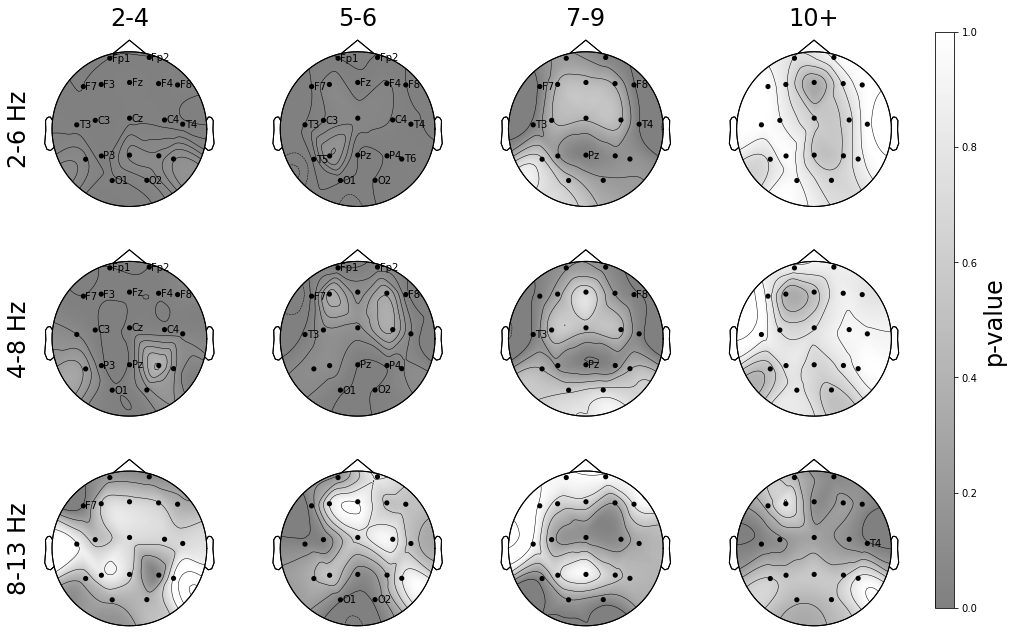

In [48]:
fig, axes = plt.subplots(3, 4, figsize=(18, 10))

for (key, val), ax in zip(p_values_1.iterrows(), axes.T.ravel()):
    im, _ = plot_topomap(val, ax, significant_1[key])

for ax, ag_name in zip(axes[0], age_groups):
    ax.set_title(ag_name, fontsize=24)

for ax, freq in zip(axes.T[0],freqs):
    ax.text(-.15, 0., freq, size=24,
            verticalalignment='center', rotation=90)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.015, 0.8])
fig.colorbar(im, cax=cbar_ax).set_label("p-value", size=24)
plt.show()

/home/max/anaconda3/envs/neuroml/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/max/anaconda3/envs/neuroml/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/max/anaconda3/envs/neuroml/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/max/anaconda3/envs/neuroml/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/max/anaconda3/envs/neuroml

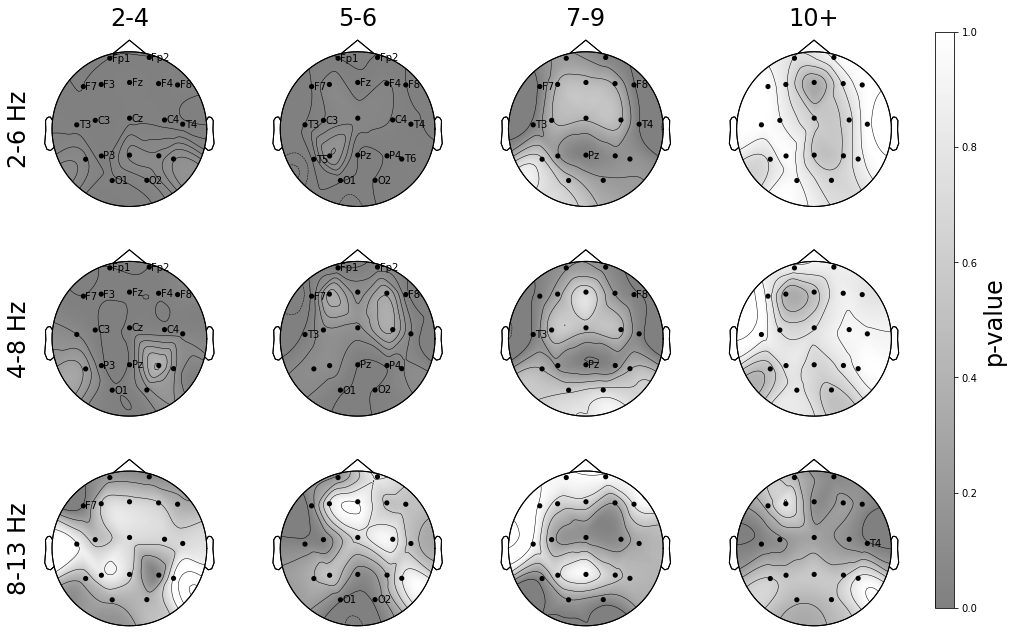

In [49]:
fig, axes = plt.subplots(3, 4, figsize=(18, 10))

for (key, val), ax in zip(p_values_2.iterrows(), axes.T.ravel()):
    im, _ = plot_topomap(val, ax, significant_2[key])

for ax, ag_name in zip(axes[0], age_groups):
    ax.set_title(ag_name, fontsize=24)

for ax, freq in zip(axes.T[0],freqs):
    ax.text(-.15, 0., freq, size=24,
            verticalalignment='center', rotation=90)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.015, 0.8])
fig.colorbar(im, cax=cbar_ax).set_label("p-value", size=24)
plt.show()

In [ ]:
p_values.to_csv("index_1_p_values.csv")

In [ ]:
p_values = pd.read_csv("index_1_p_values.csv").set_index(["age group", "kind"])